# General settings and loading of files

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

from IPython.display import display, Math, Latex
from matplotlib import cm

% matplotlib inline
% load_ext autoreload
% autoreload 2

pd.options.display.max_columns = 40  # Affy csv has 30 fields
# pd.options.display.mpl_style = 'default' # Old version of matplotlib
# mpl.style.use('default')

mpl.rc('figure', figsize=(13, 7))
mpl.rc('axes', titlesize=17, labelsize=14)
mpl.rc('xtick', labelsize=11)
mpl.rc('ytick', labelsize=11)
mpl.rc('font', family='serif')
mpl.rc('legend', fontsize=15)

In [2]:
%run helpers/data_munging_functions.py
%run helpers/number_helpers.py

In [3]:
%run discriminate_present_vs_missing.py

GALANTER_CSV = '~/tesina/galanter_SNPs.csv'
LAT1_CSV = '~/tesina/affy-LAT1/Axiom_GW_LAT.na35.annot.csv'  # 1.1Gb file!
# Smaller file for testing:
# LAT1_CSV_SMALL = "affy-LAT1/Axiom_GW_LAT.na35.annot.TRUNCATED.csv"

# lat = _create_Affymetrix_df(LAT1_CSV)

galanter, present, missing = discriminate_present_vs_missing(
    GALANTER_CSV, LAT1_CSV, dumpdir="dumpfiles")

In [4]:
print("{} Galanter AIMs".format(len(galanter)))
print("{} present in LAT".format(len(present)))
print("{} missing in LAT".format(len(missing)))

446 Galanter AIMs
180 present in LAT
266 missing in LAT


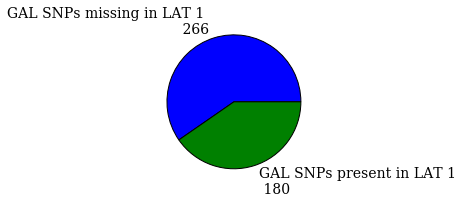

In [5]:
labels = [
    "GAL SNPs missing in LAT 1 \n %s" % len(missing),
    "GAL SNPs present in LAT 1 \n %s" % len(present)
]
snp_counts = pd.Series([len(missing), len(present)],
                       index=labels)


ax = snp_counts.plot('pie', figsize=(3,3), labeldistance=1.25, fontsize=14)
ax.set_ylabel("")
plt.show()

## Comparar Galanter.bed con Galanter de PLoS

In [6]:
galanter_updated = pd.read_csv("../galanter.bed", sep="\t", skiprows=1, 
                               names=['chr', 'pos', 'pos_to', 'id'],
                               usecols=['chr', 'pos', 'pos_to', 'id'])
galanter_updated['chr'] = galanter_updated['chr'].str.replace("chr", "").astype(int)
galanter_updated = galanter_updated.set_index('id')

In [7]:
galanter_plos = galanter[['chr', 'position']]

In [8]:
import re

galanter_dbSNP = pd.read_csv("../galanter_rsIDs_dbSNP", names=['id', 'source', 'chr', 'pos', 'pos_to'], skiprows=1).set_index('id')
take_these_out = galanter_dbSNP.chr.str.contains('HSCHR')
galanter_dbSNP = galanter_dbSNP[~take_these_out]
galanter_dbSNP['chr'] = galanter_dbSNP['chr'].astype(int)
galanter_dbSNP = galanter_dbSNP.drop_duplicates()

In [9]:
galanter_plos.index.difference(galanter_dbSNP.index)

Index(['rs5748014', 'rs8081410'], dtype='object')

In [10]:
galanter_dbSNP.index.difference(galanter_plos.index)

Index([], dtype='object')

In [11]:
comparison = galanter_plos.join(galanter_dbSNP, lsuffix='_PLOS')
diff_position = abs(comparison.position - comparison.pos) > 2
diff_chromosome = comparison.chr_PLOS - comparison.chr > 0
comparison.head()

,chr_PLOS,position,source,chr,pos,pos_to
SNP rsID,,,,,,
rs6685064,1,1201155,dbSNP,1,1275912,1275912
rs12085319,1,10952065,dbSNP,1,10969421,10969421
rs2745285,1,11549445,dbSNP,1,11566801,11566801
rs4920310,1,18436476,dbSNP,1,18237395,18237395
rs6684063,1,30471927,dbSNP,1,30226493,30226493


# I should be using info form HG last build! #FIXME
ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA_000001405.15_GRCh38/GCA_000001405.15_GRCh38_assembly_stats.txt

In [12]:
# Temporary. I'd better look for the numbers of the same build of the HG as in Galanter and HGP

HUMAN_GENOME = '/home/juan/tesina/human_genome.txt'  # Chromosome lenghts and centromeres
genome = pd.read_csv(HUMAN_GENOME, delimiter="\t")
centromere_info = genome['centromere'].apply(lambda e: pd.Series(e.split(',')).astype(int))
genome = genome.drop('centromere', axis=1)
genome = pd.concat([genome, centromere_info], axis=1)
genome = genome.set_index('ID')
genome.columns = ['length', 'centromere_start', 'centromere_end']
genome = genome.drop(['X', 'Y'])
genome.index = genome.index.rename('chr')
genome.index = genome.index.astype(int)  # This only works after removing X and Y

### Distancias entre los AIMs por cromosoma

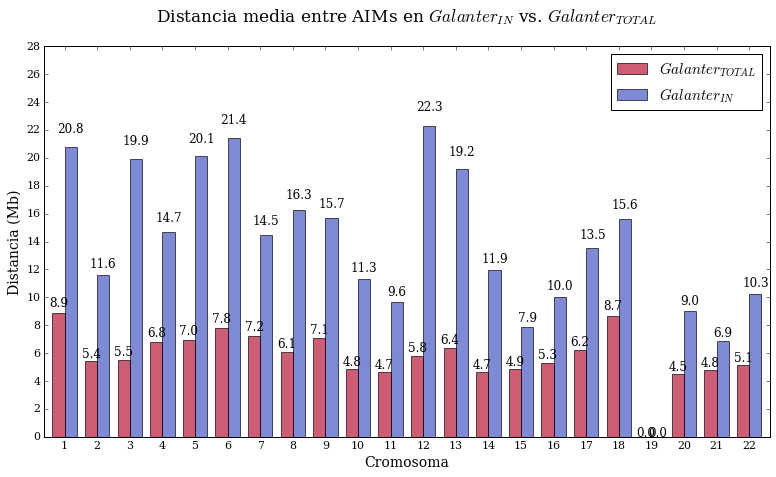

In [13]:
% run SNP_distances_plots.py

galanter_vs_present_mean_distance_plot(galanter, present, genome)
plt.show()

#### Discusión

* Las distancias medias son mucho mayores en $Galanter_{LAT}$ que en $Galanter_{all}$. En casos extremos, llega a más de 20 Mpb promedio entre AIMs, cuando esas distancias promedio no superan los 8 Mpb en el panel original.

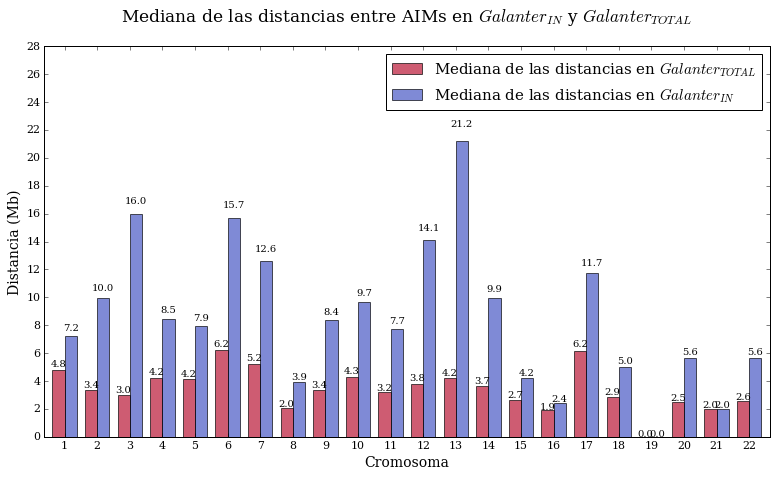

In [14]:
% run data_munging/distances.py

galanter_vs_present_median_distance_plot(galanter, present, genome)
plt.show()

### Discusión

__Nota__: hay un solo AIM en Galanter para el cromosoma 19, de modo que no se grafican distancias.

* En algunos casos extremos, hay hasta 1.4 Mpb (cromosoma 1) y 1 Mpb (cromosoma 8) de distancia entre dos AIMs contiguos.

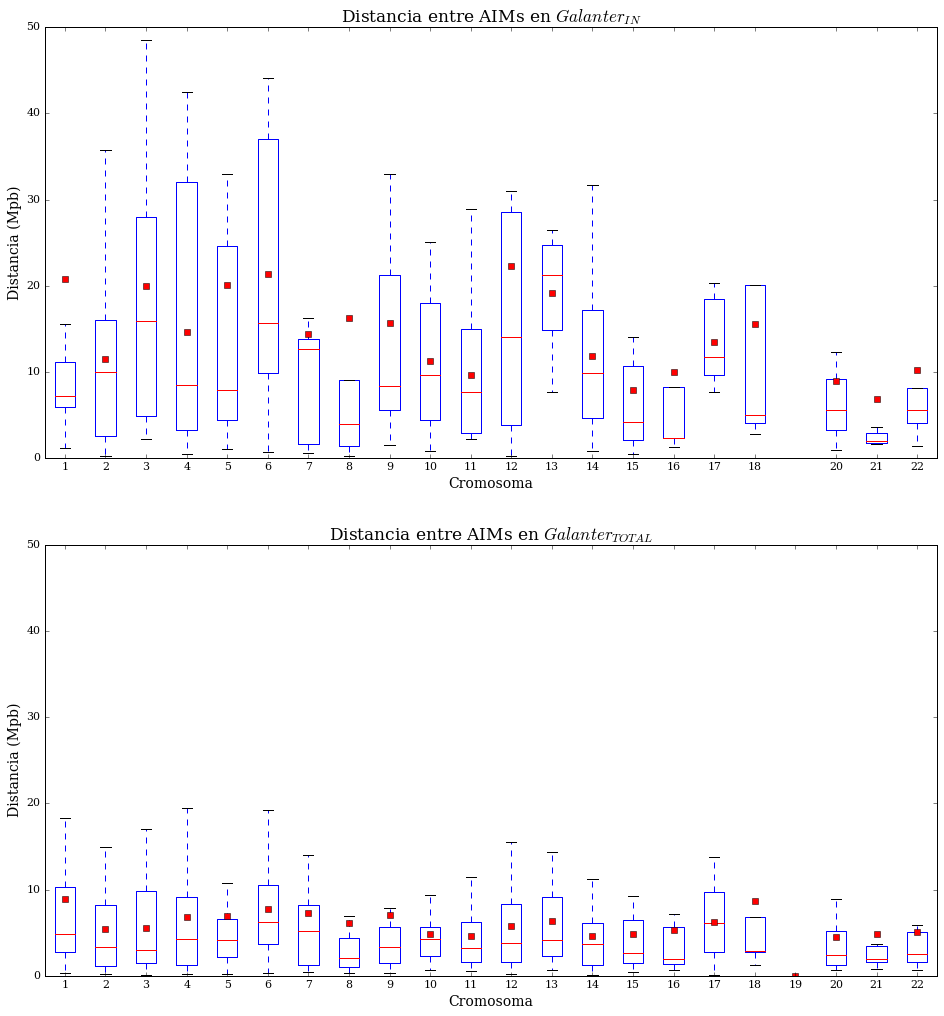

In [15]:
% run data_munging/distances.py

ax1 = plt.subplot(211)
ax1 = distances_boxplot(present, genome, ax=ax1, showfliers=False, showmeans=True,
                        title=r"Distancia entre AIMs en $Galanter_{IN}$")

ax2 = plt.subplot(212, sharey=ax1)
ax2 = distances_boxplot(galanter, genome, ax=ax2, showfliers=False, showmeans=True,
                        title=r"Distancia entre AIMs en $Galanter_{TOTAL}$")

f = ax2.figure
f.set_figheight(17)
f.set_figwidth(16)

plt.show()

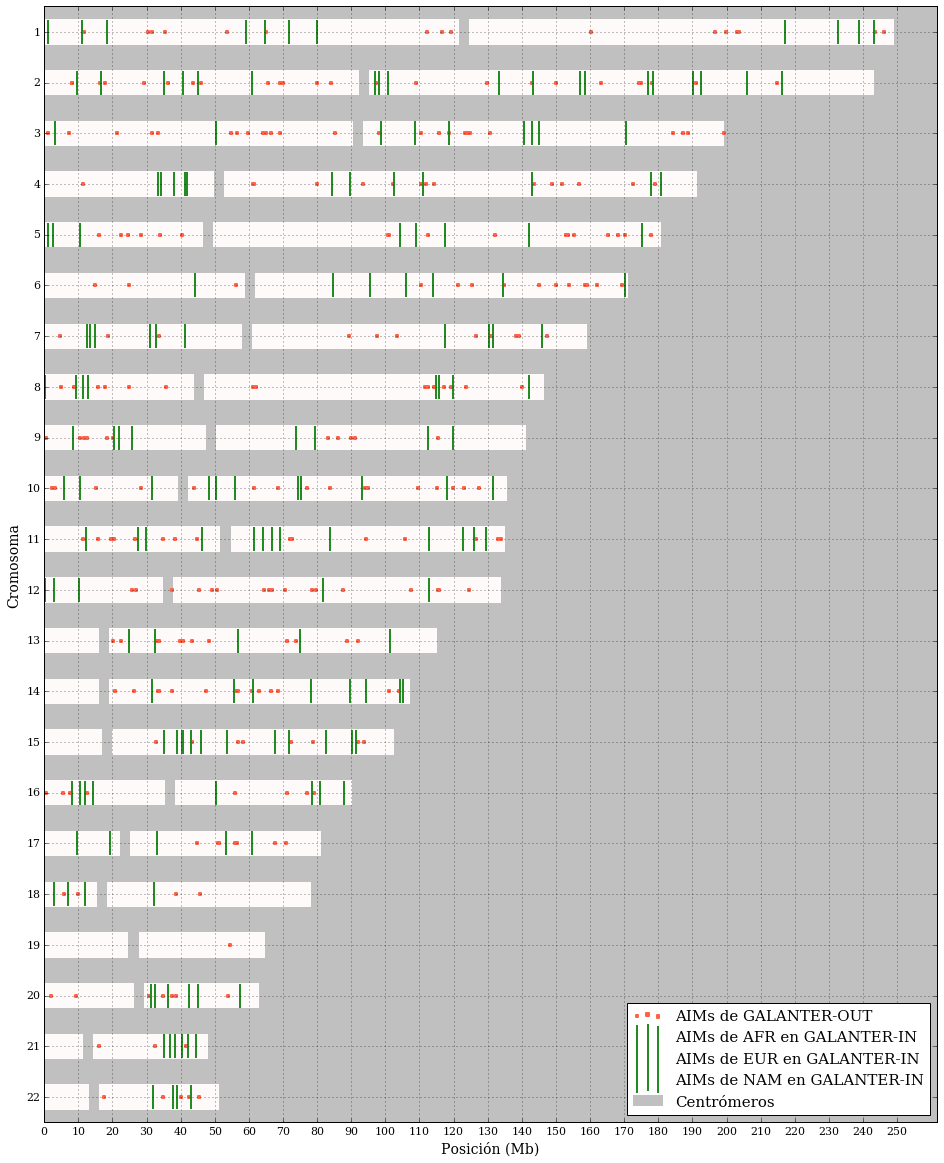

In [16]:
% run chromosomes_with_SNPs_plot.py

from collections import OrderedDict


plot_data = OrderedDict([
    ('AIMs de GALANTER-OUT',
     {'df': missing, 'marker': 's', 's': 7, 'color': 'tomato'}),
        
    ('AIMs de AFR en GALANTER-IN',
     {'df': present[present.population == "AFR"],
      'marker': '|', 'color': 'forestGreen', 's': 600}),
        
    ('AIMs de EUR en GALANTER-IN',
     {'df': present[present.population == "EUR"],
      'marker': '|', 'color': 'forestGreen', 's': 600}),
        
    ('AIMs de NAM en GALANTER-IN',
     {'df': present[present.population == "NAM"],
      'marker': '|', 'color': 'forestGreen', 's': 600}),
])

chromosomes_with_SNPs_plot(genome, plot_data)
plt.show()

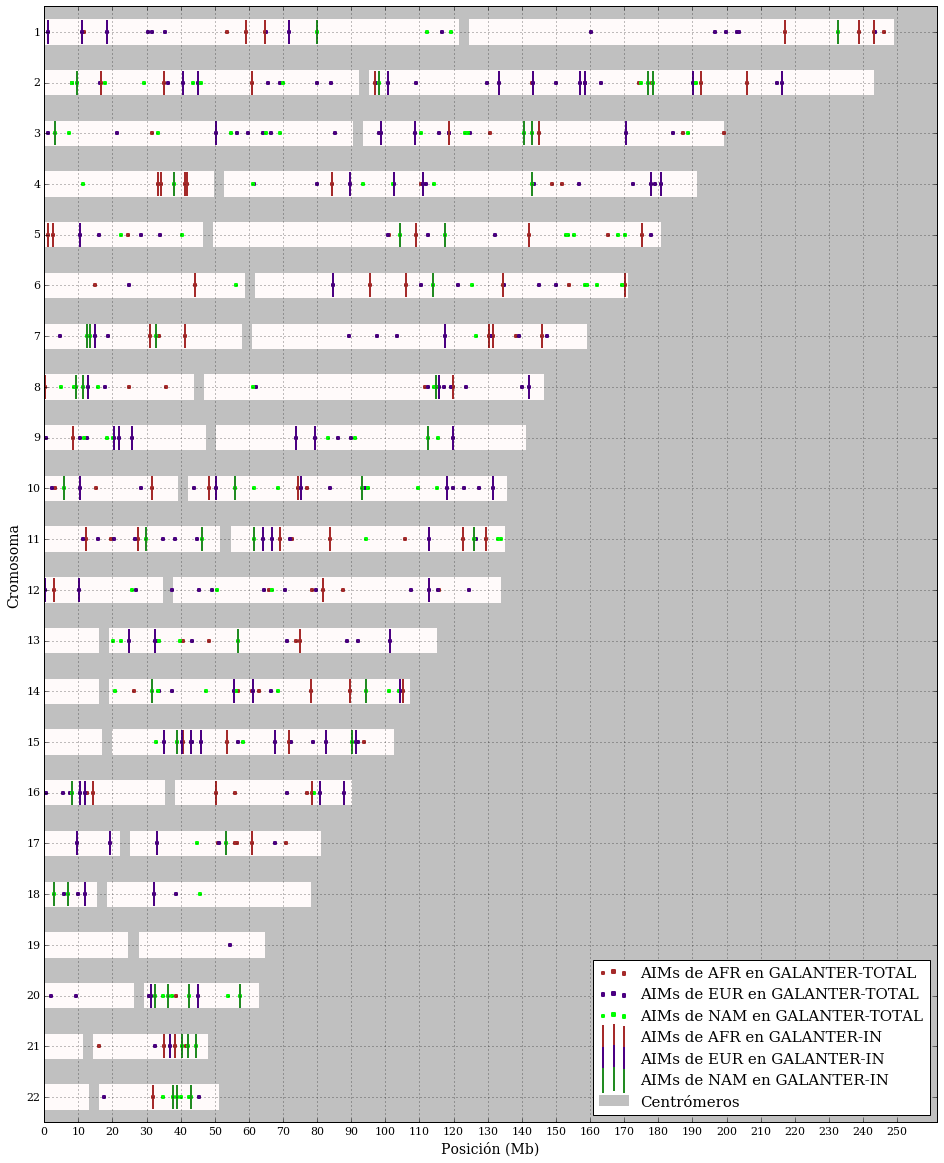

In [17]:
% run chromosomes_with_SNPs_plot.py

from collections import OrderedDict


plot_data = OrderedDict([
        
    ('AIMs de AFR en GALANTER-TOTAL',
     {'df': galanter[galanter.population == "AFR"],
      'marker': 's', 'color': 'brown', 's': 7}),
        
    ('AIMs de EUR en GALANTER-TOTAL',
     {'df': galanter[galanter.population == "EUR"],
      'marker': 's', 'color': 'indigo', 's': 7}),
        
    ('AIMs de NAM en GALANTER-TOTAL',
     {'df': galanter[galanter.population == "NAM"],
      'marker': 's', 'color': 'lime', 's': 7}),
        
    ('AIMs de AFR en GALANTER-IN',
     {'df': present[present.population == "AFR"],
      'marker': '|', 'color': 'brown', 's': 600}),
        
    ('AIMs de EUR en GALANTER-IN',
     {'df': present[present.population == "EUR"],
      'marker': '|', 'color': 'indigo', 's': 600}),
        
    ('AIMs de NAM en GALANTER-IN',
     {'df': present[present.population == "NAM"],
      'marker': '|', 'color': 'forestGreen', 's': 600}),
])

chromosomes_with_SNPs_plot(genome, plot_data)
plt.show()

In [18]:
def pop_counts(df):
    return df.groupby(['chr', 'population']).size().unstack().fillna('>> 0 <<')

df = pd.merge(pop_counts(galanter), pop_counts(present),
         left_index=True, right_index=True,
         suffixes=['_TOTAL', '_IN'])

df.columns = pd.MultiIndex.from_product([['$GALANTER_{TOTAL}$', '$GALANTER_{IN}$'],
                                         ['AFR', 'EUR', 'NAM']])
df

$GALANTER_{TOTAL}$         $GALANTER_{IN}$                  
                   AFR EUR NAM             AFR      EUR      NAM
chr                                                             
1                    8  15   4               5        4        2
2                   11  21  12               7        9        4
3                    7  16  12               2        4        3
4                    8  12   7               5        5        2
5                    8   8   9               5        1        2
6                    7   7   7               5        1        1
7                    7  10   4               5        2        3
8                    5  10   8               2        3        3
9                    1  11   7               1        6        1
10                   6  13   8               3        5        3
11                   9  12   7               6        3        4
12                   6  13   3               2        3  >> 0 <<
13                   4   8   5               1        3        1
14                   7   6   9               3        3        2
15                   4  12   4               3        7        2
16                   6   8   2               3        4        1
17                   5   5   2               1        3        1
18             >> 0 <<   5   3         >> 0 <<        2        2
20                   1   5   7         >> 0 <<        2        4
21                   4   2   3               2        1        3
22                   1   2   6               1  >> 0 <<        3

**DISCUSIÓN**

La reducción de AIMs en GALANTER-IN determina que ciertos cromosomas no tengan ningún AIM de una población determinada:

- En el cromosoma 12 se perdieron los 3 AIMs de NAM.
- En el cromosoma 20 se perdió el único AIM de AFR.
- En el cromosoma 22 se perdieron los 2 AIMs de EUR.

## Diferenciar por población de referencia, present vs galanter

     $Galanter_{IN}$  $Galanter_{TOTAL}$
AFR         0.344444            0.257848
EUR         0.394444            0.452915
NAM         0.261111            0.289238


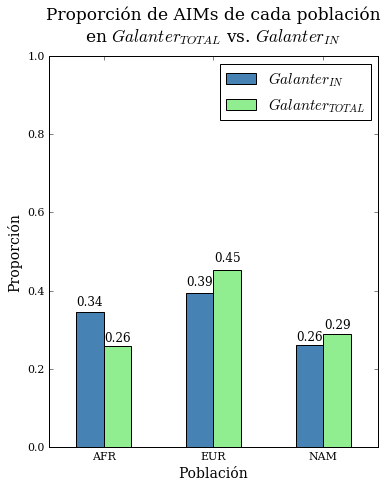

In [19]:
% run superpopulation_ratios_plot.py

superpopulation_ratios_plot(galanter, present)
plt.show()

# Traer la data de HGDP para estos SNPs

In [20]:
gt = '/home/juan/tesina/hgdp/hgdp_galanter_SNPs'
gt_head = '/home/juan/tesina/hgdp/HGDP_FinalReport_Forward__header'
rsmap = '/home/juan/tesina/hgdp/HGDP_Map.txt'
pop = '/home/juan/tesina/hgdp/hgdp-ceph-unrelated.out'

header = pd.read_csv(gt_head, sep='\t', index_col=0)
hgdp_samples = header.columns.values
hgdp_map = pd.read_csv(rsmap, sep='\t', names=['snp', 'chrom', 'pos'], index_col='snp')
hgdp_genotypes_alleles = pd.read_csv(gt, names=header, sep='\t').transpose()

hgdp_genotypes_alleles.head(2)

,rs11029687,rs11051052,rs11051552,rs11051642,rs11051825,rs17457078,rs2282751,rs2299542,rs7946724,rs10042283,rs1005932,rs10059320,rs10079352,rs10111852,rs1011489,rs10114892,rs10145908,rs10179648,rs10222597,rs10258063,...,rs8030587,rs8081410,rs820371,rs868767,rs893280,rs907687,rs918077,rs924780,rs9321456,rs9323913,rs9457490,rs9530435,rs9533623,rs956969,rs9569693,rs9569695,rs9596011,rs9642819,rs978979,rs9945476
HGDP00448,GG,AA,AG,TT,TT,TT,AG,AA,TC,TG,AA,CC,AA,CC,CC,AG,CC,TT,CC,AA,...,AA,AA,AA,AG,CC,GG,CC,AA,TC,CC,CC,TT,GG,CC,TT,GG,AG,GG,AA,GG
HGDP00479,GG,AG,GG,TT,TT,TT,AA,AA,CC,GG,AA,CC,AA,CC,CC,GG,TC,TT,CC,AG,...,AA,AA,AA,AA,CC,GG,TC,AA,CC,CC,CC,TT,GG,CC,TT,GG,GG,GG,AA,AG


In [21]:
df = pd.read_csv(pop, sep='\t', index_col='hgdp_id')
df = df.rename(columns={'population': 'subpopulation', 'Gender': 'gender'})
df['population'] = df['subpopulation'] + ', ' + df['Geographic origin']
df['gender'] = df['gender'].map({'M': 'male', 'F': 'female'})  # Homogeneize with 1000Genomes dataframe

continents = {
    'Asia': 'ASN',
    'Subsaharian Africa': 'AFR',
    'Oceania': 'ASN',
    'Europe': 'EUR',
    'Middle Est': 'ASN',
    'America': 'AMR',
    'North Africa': 'AFR',
}
df['super_population'] = df['Region'].map(continents)

hgdp_populations = df
hgdp_populations.head(2)

,gender,subpopulation,Geographic origin,Region,population,super_population
hgdp_id,,,,,,
HGDP00001,male,Brahui,Pakistan,Asia,"Brahui, Pakistan",ASN
HGDP00003,male,Brahui,Pakistan,Asia,"Brahui, Pakistan",ASN


In [22]:
hgdp_map.head(2)

,chrom,pos
snp,,
MitoA10045G,M,10045
MitoA10551G,M,10551


# Traer la data de 1000Genomes para estos SNPs

In [23]:
# %load /home/juan/tesina/1000genomes/ftp_download_1000_genomes.py

In [24]:
# % run extract_SNPs_from_vcf_chromosomes.py

# commands = extract_SNPs_from_vcf(galanter.index.values)

# ^ One time only run, to extract the SNPs out of the big files of 1000genomes:
# run_commands(commands, "/home/juan/tesina/1000genomes")

In [25]:
%run read_samples_data.py

sample_populations_file = "/home/juan/tesina/1000G_analysis/integrated_call_samples_v3.20130502.ALL.panel"
df_1000G_sample_populations = read_samples_data(sample_populations_file)

In [26]:
%run read_1000genomes_data.py
%run helpers/data_munging_functions.py

import itertools
# from glob import glob
from os.path import isfile


# vcf_filenames = glob("/home/juan/tesina/1000G_analysis/galanter_1000Genomes.vcf")
vcf_filename = "/home/juan/tesina/1000G_analysis/galanter_1000Genomes.vcf"
df_1000G_SNPs_dumpfile = "dumpfiles/1000G_SNPinfo_dataframe.csv"
df_1000G_genotypes_dumpfile = "dumpfiles/1000G_genotypes_dataframe.csv"

if not isfile(df_1000G_SNPs_dumpfile):
    # records = [_vcf_records(vcf_filename) for vcf_filename in vcf_filenames]
    records = _vcf_records(vcf_filename)
    # records = itertools.chain.from_iterable(records)  # Flattens list of lists
    records_as_dictionaries = [_vcf_record_to_dict(r) for r in records]

    # Clean up 1000genomes data
    df_1000G_SNPs = pd.DataFrame(records_as_dictionaries).set_index('ID')
    df_1000G_SNPs = df_1000G_SNPs.dropna(axis=1)
    df_1000G_SNPs = df_1000G_SNPs.drop(['FILTER', 'alleles'], axis=1)
    df_1000G_SNPs = remove_unkown_snp_subtypes(df_1000G_SNPs)
    df_1000G_SNPs = remove_unnecessary_lists_from_df(df_1000G_SNPs)

    # Get sample genotypes
    frames = [pd.DataFrame(dict(genotypes), index=[rs])
              for rs, genotypes in df_1000G_SNPs['sample_genotypes'].iteritems()]
    df_1000G_genotypes = pd.concat(frames).transpose()
    df_1000G_genotypes.to_csv(df_1000G_genotypes_dumpfile)

    # Remove big unnecessary field after exporting its data to 'samples_genotypes'
    df_1000G_SNPs = df_1000G_SNPs.drop('sample_genotypes', axis=1)
    df_1000G_SNPs.to_csv(df_1000G_SNPs_dumpfile)

df_1000G_SNPs = pd.read_csv(df_1000G_SNPs_dumpfile, index_col='ID')
df_1000G_genotypes = pd.read_csv(df_1000G_genotypes_dumpfile, index_col=0)

In [27]:
df_1000G_SNPs.head(2)

,AA,AC,AF,AFR_AF,ALT,AMR_AF,AN,CHROM,DP,EAS_AF,EUR_AF,FORMAT,NS,POS,QUAL,REF,SAS_AF,VT,call_rate,heterozygosity,is_transition,var_subtype,var_type
ID,,,,,,,,,,,,,,,,,,,,,,,
rs10751867,C|||,2866,0.572284,0.2625,T,0.6210,5008,10,19271,0.4494,0.9066,GT,2504,2349064,100,C,0.7393,SNP,1,0.489550,True,ts,snp
rs4881046,T|||,3422,0.683307,0.1649,A,0.8458,5008,10,18768,0.9335,0.8926,GT,2504,3033127,100,T,0.7955,SNP,1,0.432797,False,tv,snp


In [28]:
%run population_names.py

dumpfile = "dumpfiles/population_names.csv"
df_1000G_population_names = create_population_names_df(dumpfile)

In [29]:
ceu_description = 'Utah Residents (CEPH) with Northern ' + \
                  'and Western European Ancestry'
df_1000G_population_names = df_1000G_population_names.set_value('CEU', 'Population Description',
                                                                ceu_description)

In [30]:
def whois(pop_code):
    return df_1000G_population_names.loc[pop_code]['Population Description']

whois('ACB')

'African Caribbeans in Barbados'

In [31]:
from os.path import isfile

df = df_1000G_genotypes
df2 = pd.DataFrame(index=df.index)

alleles_dumpfile = 'dumpfiles/1000G_genotypes_alleles_dataframe'

if not isfile(alleles_dumpfile):
    def genotype_code_to_alleles(code, ref, alt):
        if code == 0:
            alleles = (ref, ref)
        elif code == 1:
            alleles = (ref, alt)
        elif code == 2:
            alleles = (alt, alt)
        else:
            raise ValueError("I don't know genotype '{}'".format(code))

        return ''.join(alleles)

    for i, (rs, genotypes) in enumerate(df.iteritems()):
        ref, alt = df_1000G_SNPs.loc[rs][['REF', 'ALT']]
        df2[rs] = genotypes.apply(genotype_code_to_alleles, args=(ref, alt))

    df2.to_csv(alleles_dumpfile)

df_1000G_genotypes_alleles = pd.read_csv(alleles_dumpfile, index_col=0)
df_1000G_genotypes_alleles.head(2)

,rs10751867,rs4881046,rs907687,rs4747860,rs1326207,rs4749305,rs3123687,rs4948800,rs709616,rs3810947,rs2795918,rs7911953,rs10997469,rs11000445,rs7080350,rs7097617,rs7902158,rs2245251,rs11186960,rs4244304,...,rs10111852,rs7048037,rs1500318,rs1535661,rs10756267,rs791654,rs10810942,rs10811305,rs3780827,rs7864029,rs1231375,rs12380601,rs7851160,rs4146171,rs4877824,rs10746839,rs1980889,rs3001115,rs10981899,rs2809393
HG00096,TT,TA,TT,CT,AA,AA,CG,CC,GG,GG,TT,TT,CT,TT,GA,AG,AG,CT,CA,CT,...,CC,GG,CC,AA,GG,AA,GA,GC,CC,GG,CC,GA,AA,TC,AG,GG,TT,CC,GG,TC
HG00097,CT,AA,TT,CC,AA,AA,GG,CC,GG,GA,TT,TT,CC,TT,AA,AG,AG,CT,CA,CC,...,TT,GG,CC,AA,GG,AA,GG,GG,CG,GG,CC,AA,AA,CC,AG,GG,TC,TC,GG,CC


## Compare SNP position 1000Genomes vs. dbSNP

In [32]:
comparison = df_1000G_SNPs[['CHROM', 'POS']].join(galanter_dbSNP)
diff_pos = abs(comparison['CHROM'] - comparison['pos']) > 2
comparison[diff_pos].head()

,CHROM,POS,source,chr,pos,pos_to
ID,,,,,,
rs10751867,10,2349064,dbSNP,10,2306870,2306870
rs4881046,10,3033127,dbSNP,10,2990935,2990935
rs907687,10,5900762,dbSNP,10,5858799,5858799
rs4747860,10,10540164,dbSNP,10,10498201,10498201
rs1326207,10,15166905,dbSNP,10,15124906,15124906


In [33]:
def maf_by_population_from_genotypes(df_genotypes, df_populations, dumpfile):

    if not isfile(dumpfile):
        freq_by_population = defaultdict(dict)

        for rs, genotypes in df_genotypes.iteritems():
            ref_alleles_count = defaultdict(lambda: 0)
            total_alleles_count = defaultdict(lambda: 0)
            ref = df_genotypes.iloc[1, 1][0]  # Arbitrarily pick a ref allele for the count

            for sample, genotype in genotypes.iteritems():
                # genotype is a 'TT' or 'TC' like string, transform it to a number of ref_alleles
                ref_count = genotype.count(ref)
                try:
                    population = df_populations.loc[sample].population
                    super_population = df_populations.loc[sample].super_population
                except KeyError:
                    continue
                ref_alleles_count[population] += ref_count
                ref_alleles_count[super_population] += ref_count
                total_alleles_count[population] += 2
                total_alleles_count[super_population] += 2

            for population, ref_alleles in ref_alleles_count.items():
                freq_by_population[rs][population] = ref_alleles / total_alleles_count[population]

        freqs = pd.DataFrame(dict(freq_by_population)).transpose()
        mafs = freqs.applymap(lambda freq: min(freq, 1 - freq))
        mafs.to_csv(dumpfile)

    return pd.read_csv(dumpfile, index_col=0)

In [34]:
# !rm dumpfiles/HGDP_MAF_per_population.csv

maf_HGDP = maf_by_population_from_genotypes(
    hgdp_genotypes_alleles, hgdp_populations,
    "dumpfiles/HGDP_MAF_per_population.csv"
)
maf_HGDP.head(2)

,AFR,AMR,ASN,"Adygei, Russia Caucasus","Balochi, Pakistan","Bantu_N.E., Kenya","Bantu_S.E._Pedi, South Africa","Bantu_S.E._S.Sotho, South Africa","Bantu_S.E._Tswana, South Africa","Bantu_S.E._Zulu, South Africa","Bantu_S.W._Herero, South Africa","Bantu_S.W._Ovambo, South Africa","Bedouin, Israel (Negev)","Biaka_Pygmies, Central African Republic","Brahui, Pakistan","Burusho, Pakistan","Cambodians, Cambodia","Colombians, Colombia","Dai, China","Daur, China",...,"Orcadian, Orkney Islands","Oroqen, China","Palestinian, Israel (Central)","Papuan, New Guinea","Pathan, Pakistan","Pima, Mexico","Russian, Russia","San, Namibia","Sardinian, Italy","She, China","Sindhi, Pakistan","Surui, Brazil","Tu, China","Tujia, China","Tuscan, Italy","Uygur, China","Xibo, China","Yakut, Siberia","Yizu, China","Yoruba, Nigeria"
rs10042283,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0,0,0,0.000000,0.000000,0.00,0.00,0.0,0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0,0.0,0.0,0.000000,0.0,0.000000,0,0.0,0.00,0.0,0.0,0.000000,0.00,0.00,0.000000
rs1005932,0.096154,0.03125,0.460102,0.323529,0.458333,0.045455,0.5,0,0,0,0,0,0.184783,0.095238,0.48,0.26,0.3,0,0.5,0.444444,...,0.266667,0.388889,0.326087,0.5,0.363636,0,0.4,0.1,0.267857,0.5,0.395833,0,0.4,0.35,0.5,0.2,0.444444,0.46,0.45,0.071429


In [35]:
# !rm dumpfiles/1000G_MAF_per_population.csv

maf_1000G = maf_by_population_from_genotypes(
    df_1000G_genotypes_alleles, df_1000G_sample_populations,
    "dumpfiles/1000G_MAF_per_population.csv"
)
maf_1000G.head(2)

,ACB,AFR,AMR,ASW,BEB,CDX,CEU,CHB,CHS,CLM,EAS,ESN,EUR,FIN,GBR,GIH,GWD,IBS,ITU,JPT,KHV,LWK,MSL,MXL,PEL,PJL,PUR,SAS,STU,TSI,YRI
rs10026397,0.145833,0.080938,0.180115,0.237705,0.395349,0.123656,0.191919,0.135922,0.080952,0.18617,0.117063,0.055556,0.16998,0.156566,0.159341,0.42233,0.026549,0.149533,0.416667,0.100962,0.146465,0.060606,0.058824,0.125,0.117647,0.354167,0.259615,0.404908,0.431373,0.191589,0.050926
rs10042283,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Comparar SNPs

In [36]:
print("1000 Genomas:", len(df_1000G_SNPs))
print("Galanter panel:", len(galanter))

1000 Genomas: 442
Galanter panel: 446


**NOTA** sobre los 4 SNPs que faltan
- un SNP tiene mal el cromosoma en Galanter
- en el proceso de leer la data de 1000 genomas estoy dejando afuera tres SNPs, porque tienen más de 2 variantes.

In [37]:
missing_in_1000g = set(galanter.index) - set(df_1000G_SNPs.index)
galanter.loc[missing_in_1000g]

,chr,position,A1,A2,NAM_AF,EUR_AF,AFR_AF,population,LSBL(Fst),LSBL(In)
SNP rsID,,,,,,,,,,
rs2510719,11,126511001,A,C,0.034,0.574,0.039,EUR,0.341,0.196
rs12065716,1,116575568,G,C,0.389,0.885,0.136,EUR,0.372,0.207
rs10071261,5,1066694,T,C,0.107,0.086,0.903,AFR,0.650,0.375
rs2242865,21,15948902,G,T,0.011,0.156,0.932,AFR,0.695,0.422


In [38]:
galanter.loc['rs3911610'][['A1', 'A2']]

A1    C
A2    T
Name: rs3911610, dtype: object

### Crear listas de SNPs ya filtradas para GAL total y GAL parcial

In [39]:
df_1000G_SNPs.index.values.tofile(
    "../admixture/galT.snps", sep="\n", format="%s"
)
df_1000G_SNPs.index.intersection(present.index).values.tofile(
    "../admixture/galP.snps", sep="\n", format="%s"
)

### Ver qué subpoblaciones se van en $Galanter_{IN}$ y cuáles quedan

/home/juan/Dropbox/bio/tesina/notebook/analyze_populations_in_galanter.py:9: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  df.boxplot(rot=90, showmeans=True)


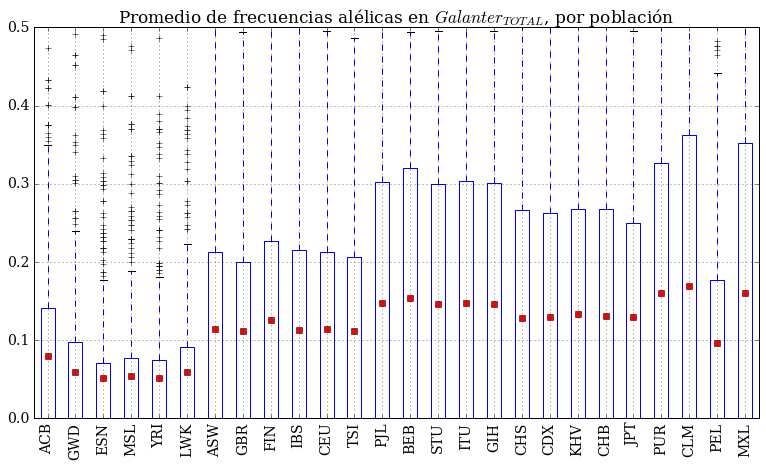

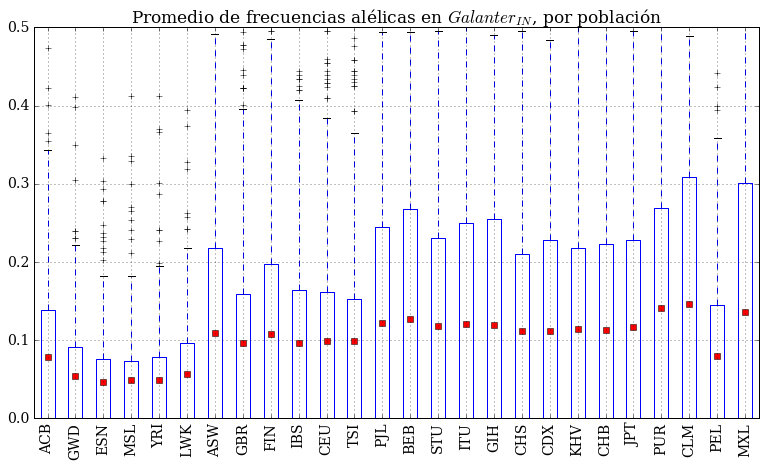

In [40]:
% run analyze_populations_in_galanter.py

populations_to_plot = []

for superpop in ['AFR', 'EUR', 'SAS', 'EAS', 'AMR']:
    pops = df_1000G_sample_populations[df_1000G_sample_populations.super_population == superpop].population.unique()
    populations_to_plot += list(pops)

dfs = {'$Galanter_{IN}$': present,
       '$Galanter_{TOTAL}$': galanter}

for name, df in dfs.items():
    df = df.join(maf_1000G).filter(regex='|'.join(populations_to_plot))
    df = df[populations_to_plot]
    
    ax = boxplot_freqs_by_populations(
        df, populations_to_plot,
        title="Promedio de frecuencias alélicas en {}, por población".format(name),
    )
    ax.set_ylim((0, 0.5))
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

/home/juan/miniconda3/envs/rkernel/lib/python3.4/site-packages/ipykernel/__main__.py:8: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


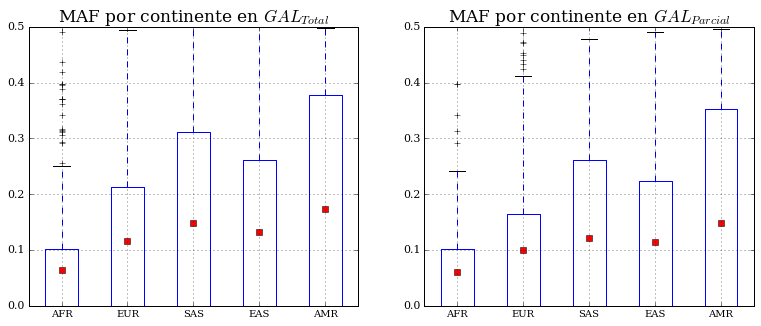

In [41]:
fig, axes = plt.subplots(1, 2, sharey=False)
titles = ("MAF por continente en $GAL_{Total}$",
          "MAF por continente en $GAL_{Parcial}$" )

for i, df in enumerate([galanter, present]):
    ax = axes[i]
    df = df.join(maf_1000G).filter(['AFR', 'EUR', 'SAS', 'EAS', 'AMR'])
    df.boxplot(ax=ax, rot=0, showmeans=True)
    ax = axes[i]
    ax.set_title(titles[i])
    ax.set_ylim((0, 0.5))
    ax.axhline(0.5, color='salmon', linestyle='--')

fig.set_figheight(5)
plt.show()

/home/juan/miniconda3/envs/rkernel/lib/python3.4/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


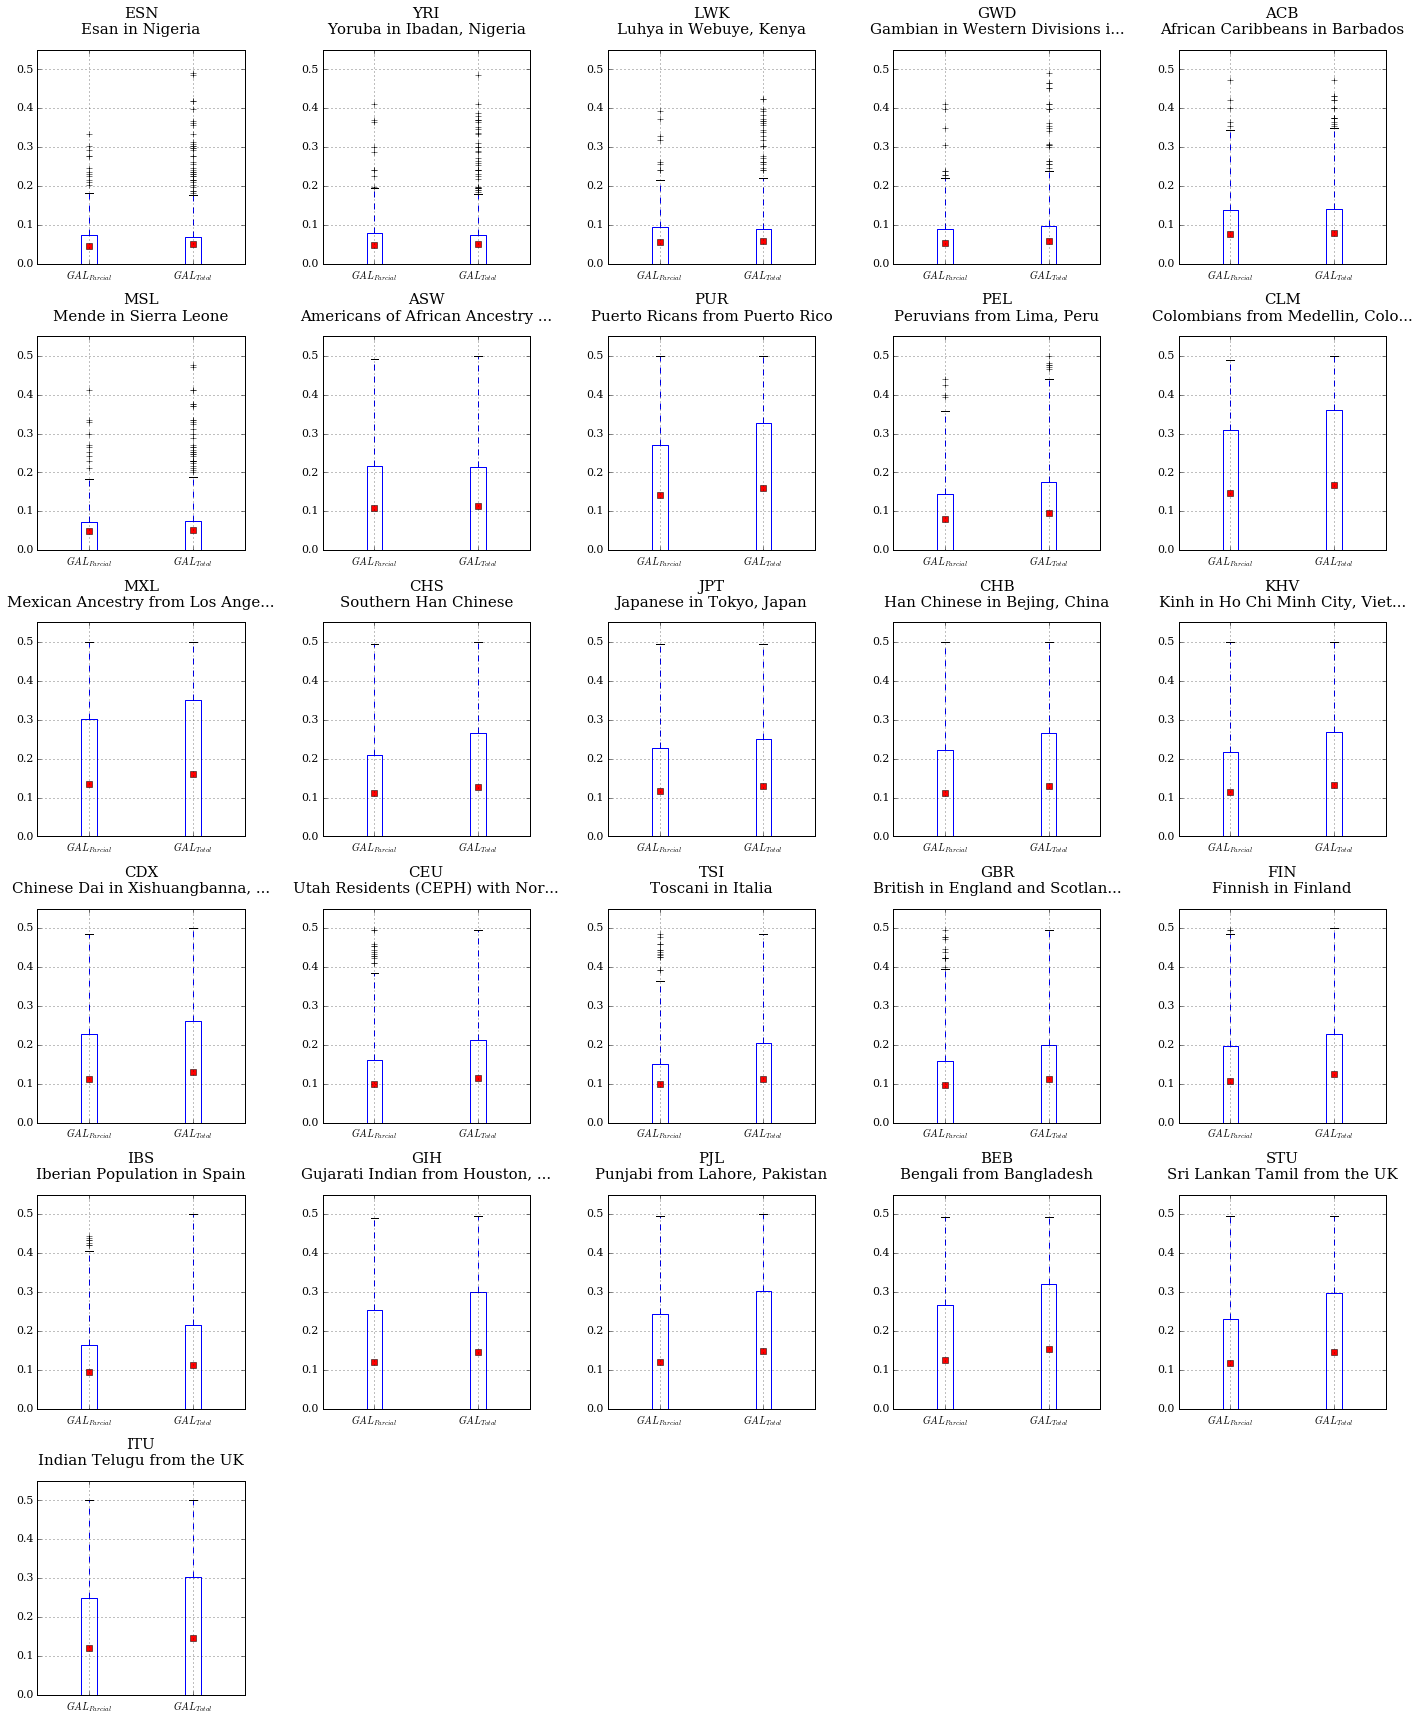

In [42]:
% run helpers/text_helpers.py

populations_to_plot = [p for p in df_1000G_sample_populations.sort('super_population')['population'].unique()]

get_freqs = lambda df: df.join(maf_1000G)[populations_to_plot]

chart_width = 4
chart_height = 4
fig_rows = 6
fig_cols = 5

fig = plt.figure(figsize=(fig_cols * chart_height, fig_rows * chart_width))

for i, population in enumerate(populations_to_plot):
    df = pd.DataFrame({'$GAL_{Parcial}$': get_freqs(present)[population],
                       '$GAL_{Total}$': get_freqs(galanter)[population]})

    ax = plt.subplot(fig_rows, fig_cols, i+1)
    pop_description = df_1000G_population_names.loc[population]['Population Description']
    ax.set_title(population + "\n" + trunc_text(pop_description, 30), y=1.05, fontsize=15)    
    df.boxplot(ax=ax, showmeans=True, return_type='both')
    ax.set_ylim((0, 0.55))

plt.tight_layout()
plt.show()

In [43]:
mean_frequencies = lambda df: maf_1000G.loc[df.index].mean()
std_frequencies = lambda df: maf_1000G.loc[df.index].std()

In [44]:
import numpy as np
from collections import OrderedDict

df = pd.DataFrame(OrderedDict([
    ('$GAL_{Total}$', mean_frequencies(galanter)),
    ('$GAL_{Parcial}$', mean_frequencies(present)),
    ('Freq. Diff.', mean_frequencies(galanter) - mean_frequencies(present)),
]))

df = df.applymap(lambda n: round(n, 2))
freq_diff = df.join(df_1000G_population_names[['Population Description', 'Super Population Code']]).fillna('')
freq_diff = freq_diff.rename(columns={'Population Description': 'Population'})
freq_diff = freq_diff.drop('Super Population Code', axis=1)
freq_diff = freq_diff[freq_diff['Population'] != '']  # Removes superpopulations
freq_diff.sort_values(by='Freq. Diff.', ascending=False)

,$GAL_{Total}$,$GAL_{Parcial}$,Freq. Diff.,Population
PJL,0.15,0.12,0.03,"Punjabi from Lahore, Pakistan"
BEB,0.15,0.13,0.03,Bengali from Bangladesh
STU,0.15,0.12,0.03,Sri Lankan Tamil from the UK
ITU,0.15,0.12,0.03,Indian Telugu from the UK
GIH,0.15,0.12,0.03,"Gujarati Indian from Houston, Texas"
IBS,0.11,0.10,0.02,Iberian Population in Spain
MXL,0.16,0.14,0.02,Mexican Ancestry from Los Angeles USA
PUR,0.16,0.14,0.02,Puerto Ricans from Puerto Rico
KHV,0.13,0.11,0.02,"Kinh in Ho Chi Minh City, Vietnam"
PEL,0.10,0.08,0.02,"Peruvians from Lima, Peru"


### Comparación de la "heterocigosidad"

/home/juan/miniconda3/envs/rkernel/lib/python3.4/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


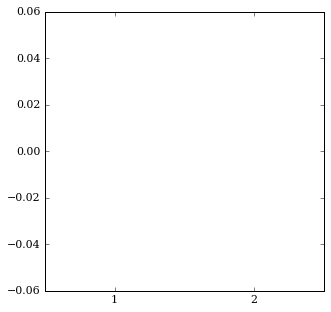

In [45]:
galanter_heter = galanter.join(df_1000G_SNPs, rsuffix='_').heterozygosity
present_heter = present.join(df_1000G_SNPs, rsuffix='_').heterozygosity

plt.figure(figsize=(5, 5))
ax = plt.subplot(111)
ax.boxplot([galanter_heter, present_heter])
# ax.set_xticklabels(['$Galanter_{TOTAL}$', '$Galanetr_{IN}$'])
# ax.set_ylim([0, .55])
plt.show()

# Preparar datos para PCA y ADMIXTURE

# PCA

## Preparar datasets de muestras elegidas

In [46]:
from collections import OrderedDict

samples = df_1000G_sample_populations

def merge_dicts(*dict_args):
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

def indices(pop_dict):  
    populations = []
    for label, pop_list in pop_dict.items():
        mask = samples.population.isin(pop_list)
        populations.append(samples[mask])
        #print(len(samples[mask]), label)

    #print('-----')
    #print(len(pd.concat(populations)), 'total')
    #print()
    return pd.concat(populations).index

datasets_general = OrderedDict()
datasets_by_pop = OrderedDict()

all_latinos = {'latinos': ['PEL', 'MXL', 'CLM', 'PUR']}
e = {'europeans': ['IBS', 'TSI']}
ea = merge_dicts(e, {'africans': ['YRI', 'LWK']})
eac = merge_dicts(ea, {'east_asians': ['CHB', 'CHS']})
eaci = merge_dicts(eac, {'south_asians': ['GIH']})

datasets_general['Latinos'] = all_latinos
datasets_general['Latinos, Europeos'] = merge_dicts(e, all_latinos)
datasets_general['Latinos, Europeos, Africanos'] = merge_dicts(ea, all_latinos)
datasets_general['Latinos, Europeos, Africanos, Chinos'] = merge_dicts(eac, all_latinos)
datasets_general['Latinos, Europeos, Africanos,\nChinos, Indios'] = merge_dicts(eaci, all_latinos)

#for lat in all_latinos['latinos']:
#    datasets_by_pop['LEA_' + lat] = merge_dicts(ea, {'latinos': [lat]})

# Transform population codes into dataframe indices (sample IDs)
# And write the sample IDs list to a file with the dataset name
for dataset_group in [datasets_general, datasets_by_pop]:
    for label, pop_dict in dataset_group.items():
        dataset_group[label] = indices(pop_dict)
        filename = "_".join(label.replace("\n", " ").split(", ")).lower()
        dataset_group[label].values.tofile("./data/" + filename,
                                           sep="\n", format="%s")

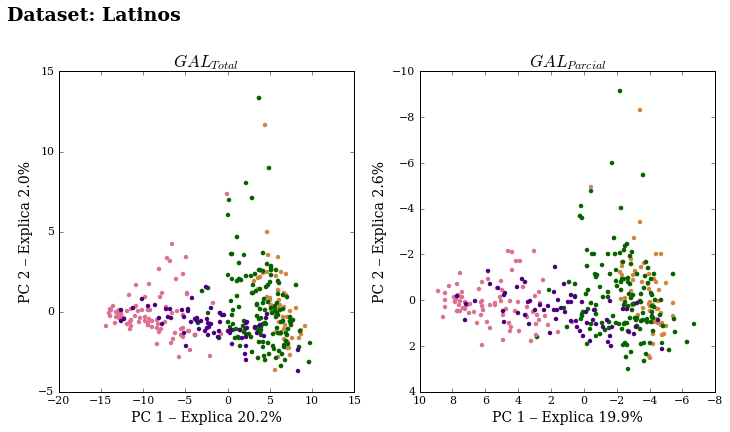

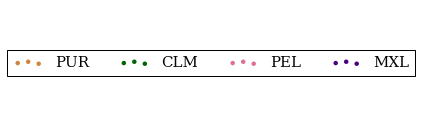

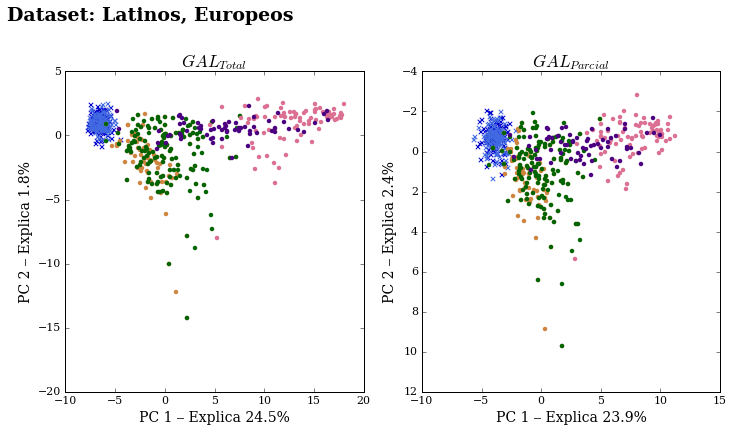

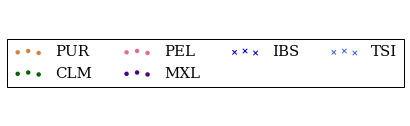

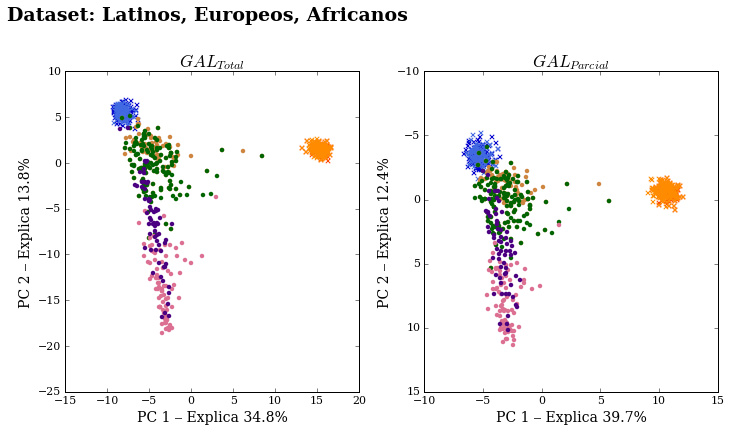

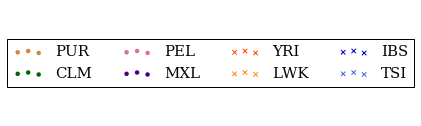

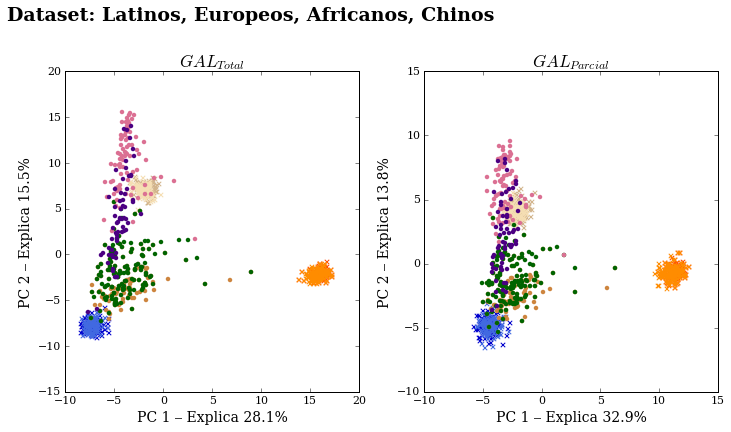

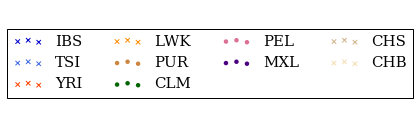

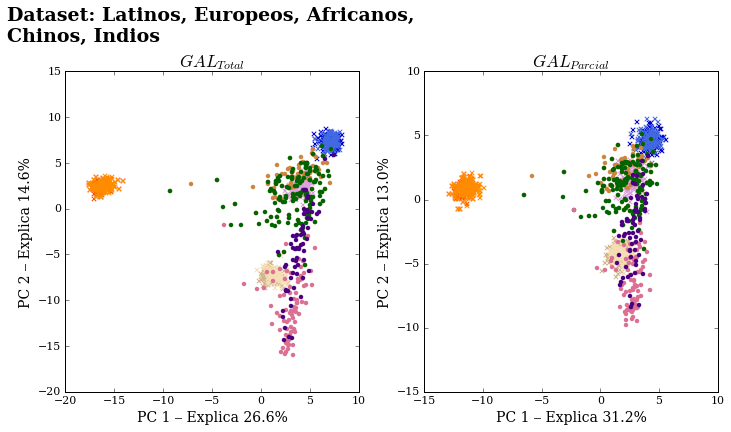

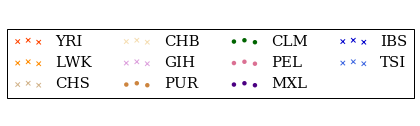

In [150]:
%run plot_PCAs.py

panels = OrderedDict()
panels['$GAL_{Total}$'] = galanter.index
panels['$GAL_{Parcial}$'] = present.index

markers = {
    'PUR': 'o',
    'CLM': 'o',
    'PEL': 'o',
    'MXL': 'o',
    
    'YRI': 'x',
    'LWK': 'x',
    
    'IBS': 'x',
    'TSI': 'x',
    
    'CHS': 'x',
    'CHB': 'x',
    
    'GIH': 'x',
}

colors = {
    'PUR': 'Peru',
    'CLM': 'DarkGreen',
    'PEL': 'PaleVioletRed',
    'MXL': 'Indigo',
    
    'YRI': 'OrangeRed',
    'LWK': 'DarkOrange',
    
    'IBS': 'MediumBlue',
    'TSI': 'RoyalBlue',

    'CHS': 'Tan',
    'CHB': 'Wheat',

    'GIH': 'Plum',
}


for dataset_label, indices in datasets_general.items():
    genotypes = df_1000G_genotypes.loc[indices, :]
    
    # Hardcoding axis inversion, this would be overly complicated
    # to automate. 
    invert_y = len(dataset_label.split(',')) <= 3
    invert_x = dataset_label == 'Latinos'
    
    pca = plot_PCAs(dataset_label, panels, genotypes,
                    df_1000G_sample_populations,
                    markers, colors, invert_y, invert_x)

# Add a function to print some pca stats like cum explained variance

# Leer resultados de ADMIXTURE

## Plot CV Errors for different K values

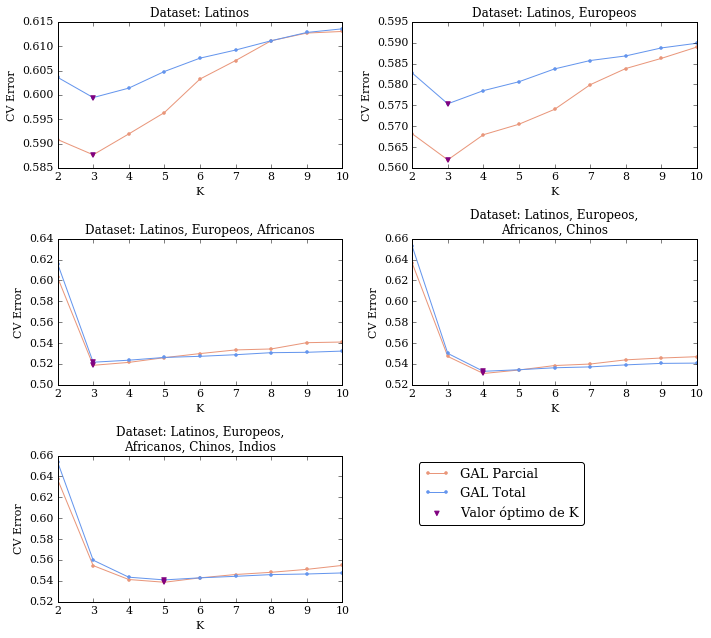

In [48]:
from itertools import product

cv_errors = pd.read_csv("../admixture/CV_error_summary.clean",
                        names=['dataset_panel', 'K', 'CV_error'])

cv_errors['dataset'] = cv_errors['dataset_panel'].apply(lambda x: x.split("_")[0])
cv_errors['panel'] = cv_errors['dataset_panel'].apply(lambda x: x.split("_")[1])
cv_errors = cv_errors.drop('dataset_panel', axis=1)
cv_errors = cv_errors.set_index(['dataset', 'panel', 'K']).sort_index()

dataset_names = {
    "L": "Latinos",
    "LE": "Latinos, Europeos",
    "LEA": "Latinos, Europeos, Africanos",
    "LEAC": "Latinos, Europeos,\nAfricanos, Chinos",
    "LEACI": "Latinos, Europeos,\nAfricanos, Chinos, Indios"
}

panel_names = {
    "galP": "GAL Parcial",
    "galT": "GAL Total",
}

datasets = cv_errors.index.get_level_values('dataset').unique()
panels = cv_errors.index.get_level_values('panel').unique()
Ks = cv_errors.index.get_level_values('K').unique()

width, height = (5, 3)
cols, rows = (2, 3)
fig = plt.figure(figsize=(width * cols, height * rows))
axes = list(np.arange(cols * rows) + 1)
axes.reverse()

for dataset in datasets:
    ax = plt.subplot(rows, cols, axes.pop())
    lines = []
    
    for panel in panels:
        color = "CornflowerBlue" if panel == "galT" else "DarkSalmon"
        data = cv_errors.loc[(dataset, panel)]
        data.plot(ax=ax, marker=".", color=color, zorder=1)
        
        x_min = data['CV_error'].idxmin()
        y_min = data['CV_error'].min()
        min_marker = ax.scatter(x_min, y_min, marker="v", color="Purple", zorder=2)
        
        # TODO: Add a special mark at the minimum y value
    
    lines, labels = ax.get_legend_handles_labels()
    panel_labels = [panel_names[panel] for panel in panels]
    ax.set_title("Dataset: " + dataset_names[dataset], fontsize=12)
    ax.set_ylabel("CV Error", fontsize=11)
    ax.set_xlabel("K", fontsize=11)
    ax.legend().set_visible(False)

# Ugly hack to get the legend in a separate subplot slot
ax = plt.subplot(rows, cols, axes.pop())
ax.legend(lines + [min_marker], panel_labels + ['Valor óptimo de K'],
          fontsize=13, loc='upper left', fancybox=True, scatterpoints=1)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
for loc in ['top', 'bottom', 'left', 'right']:
    ax.spines[loc].set_visible(False)

plt.tight_layout()
plt.show()

## Plot ADMIXTURE ancestry ratios per individual

In [200]:
from collections import OrderedDict
from collections import defaultdict


dataset_Ks = OrderedDict([("L", 3), ("LE", 3), ("LEA", 3), ("LEAC", 4), ("LEACI", 5)])
panels = ["galT", "galP"]
admixture_results = defaultdict(OrderedDict)

for dataset_tag, optimal_K in dataset_Ks.items():
    for panel_tag in panels:
        fdir = "../admixture/{}_{}/".format(dataset_tag, panel_tag)
        filename = "{}_{}.{}.Q".format(dataset_tag, panel_tag, optimal_K)
        samples_filename = "{}_{}.fam".format(dataset_tag, panel_tag)
        ancestry_values = pd.read_csv(fdir + filename, sep="\s+",
                                      names=list(range(optimal_K)))
        sample_ids = pd.read_csv(fdir + samples_filename, sep="\s+",
                                 index_col=0, usecols=[0], names=['sample_id'])
        ancestry_values['sample_id'] = sample_ids.index
        populations = df_1000G_sample_populations.loc[sample_ids.index]['population']
        ancestry_values['population'] = populations.values

        # Reorder ancestry ratio columns for some cases (hardcoded)
        if panel_tag == "galP":
            if dataset_tag == "LE":
                ancestry_values = ancestry_values[[1, 0, 2, 'sample_id', 'population']]
            if dataset_tag == "LEA":
                ancestry_values = ancestry_values[[0, 2, 1, 'sample_id', 'population']]
            if dataset_tag == "LEAC":
                ancestry_values = ancestry_values[[2, 3, 0, 1, 'sample_id', 'population']]

        ancestry_values = ancestry_values.sort_values(['population', 0])
        admixture_results[dataset_tag][panel_tag] = ancestry_values

In [183]:
[x for x in [1, 2]]

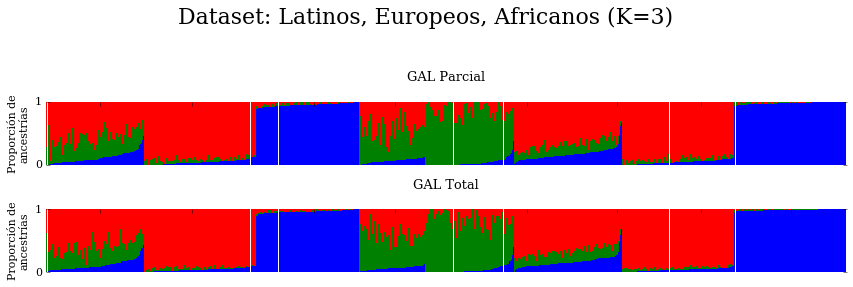

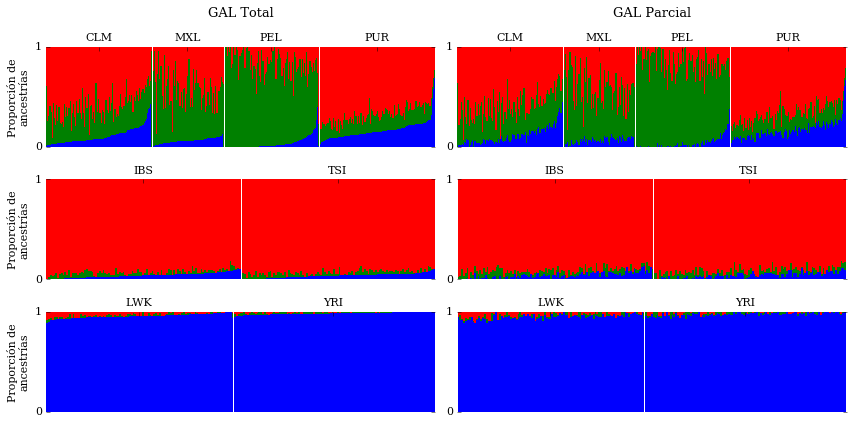

In [208]:
from collections import OrderedDict


lat = ['CLM', 'MXL', 'PEL', 'PUR']
afr = ['LWK', 'YRI']
eur = ['TSI', 'IBS']
chi = ['CHS', 'CHB']
ind = ['GIH']

population_groups = OrderedDict([('Latinos', lat), ('Europeos', eur),
                                 ('Africanos', afr), ('Chinos', chi),
                                 ('Indios', ind)])

def config_admixture_plot(ax, df):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set population names on the xticks
    indices_by_population = [df[df['population'] == population].index.values
                             for population in df['population'].unique()]
    xtick_positions = [np.median(indices) for indices in indices_by_population]
    ax.xaxis.set_ticks_position("top")
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(df_pop['population'].unique(), rotation=0)

    # Separate the populations with a line
    separation_lines = [min(indices) for indices in indices_by_population]
    [plt.axvline(x=x, color="w", lw=1) for x in separation_lines[1:]]


    
    ax.set_ylim((0, 1))
    ax.set_yticks([0, 1])
    ax.set_frame_on(False)
    ax.legend().set_visible(False)

    return ax

for dataset_tag, panel_results in admixture_results.items():
    K = dataset_Ks[dataset_tag]
    dataset_name = dataset_names[dataset_tag].replace("\n", "")
    
    if dataset_tag != "LEA": ####
        continue ####

    # One figure per panel / dataset on top
    
    rows = len(panels)
    fig = plt.figure(figsize=(12, 2 * rows))
    axes = (np.arange(len(panels)) + 1).tolist()
    
    for panel_tag, df in panel_results.items():
        panel_name = panel_names[panel_tag]
        ax = plt.subplot(rows, 1, axes.pop())
        df.plot(ax=ax, kind="bar", stacked=True, width=1, linewidth=0)
        ax = config_admixture_plot(ax, df)
        ax.set_title(panel_name, fontsize=13, position=(0.5, 1.25))
        ax.set_ylabel("Proporción de\nancestrías", fontsize=11)
    
    plt.tight_layout()
    title = "Dataset: {} (K={})".format(dataset_name, K)
    fig.suptitle(title, fontsize=22, fontweight="ultralight", variant="small-caps")
    plt.subplots_adjust(top=(0.65))
    plt.show()
    
    
    # Detail plots for each population
    
    # Figure dimensions and subplot number generation
    width, height = (6, 2)
    
    # Hacky! Dataset tags are acronyms of the population groups. I'm so sorry.
    cols, rows = (2, len(dataset_tag))
    
    fig = plt.figure(figsize=(width * cols, height * rows))

    odd_subplots = [n for n in np.arange(rows * cols) + 1 if n % 2 != 0]
    even_subplots = list(np.array(odd_subplots) + 1)
    axes = {"galT": odd_subplots[::-1], "galP": even_subplots[::-1]}

    sorted_index = []  # Hack. See (1) below.

    # One subplot per panel / population group in the dataset
    for panel_tag, df in panel_results.items():
        panel_name = panel_names[panel_tag]
        
        for population_group_name, population_group in population_groups.items():
            mask = df['population'].isin(population_group)
            df_pop = df[mask].dropna()
            if len(df_pop) == 0:
                continue
    
            # (1) Hack to get the same sample order in both columns of plots
            if panel_tag == "galT":
#                 df_pop = df_pop.sort_values(['population', 0])
                sorted_index = [df_pop.index] + sorted_index
            else:
                df_pop = df_pop.loc[sorted_index.pop()]

            # I need consecutive indices for the xtick labels position calculation later:
            df_pop = df_pop.reset_index(drop=True)
            
            ax_id = axes[panel_tag].pop()
            ax = plt.subplot(rows, cols, ax_id)
            df_pop.plot(ax=ax, kind="bar", stacked=True, width=1, linewidth=0)
            ax = config_admixture_plot(ax, df_pop)
            
            # Top plots carry the panel_name as title
            if ax_id in [1, 2]:
                ax.set_title(panel_name, fontsize=13, position=(0.5, 1.25))

            # Plots on the left (odd plots) carry the y-axis label
            if ax_id % 2 != 0:
                ax.set_ylabel("Proporción de\nancestrías", fontsize=11)

#             ax.axes.get_yaxis().set_visible(True)
#             ax.axes.get_xaxis().set_visible(True)


    plt.tight_layout()
#     title = "Dataset: {} (K={})".format(dataset_name, K)
#     fig.suptitle(title, fontsize=16, fontweight="bold")
#     plt.subplots_adjust(top=(0.04 * rows + 0.7))
    plt.show()

# Ver si HDGP tiene estos SNPs